In [584]:
from cobra.io import read_sbml_model
from cobra import Reaction
from cobra.flux_analysis.phenotype_phase_plane import production_envelope
from cobra.flux_analysis import moma
import numpy as np

model = read_sbml_model('iML1515.xml')

# Check genes

In [585]:
genes = ["b0677", "b0678", "b0679", "b1817", "b1818", "b1819", "b1101", "b2415", "b2416", "b2417"]
essentiality = {}
for gene in genes:
    with model:
        model.genes.get_by_id(gene).knock_out()
        essentiality[gene] = model.slim_optimize(error_value=0.)

In [586]:
essentiality

{'b0677': 0.8769972144269641,
 'b0678': 0.876997214426954,
 'b0679': 0.876997214426954,
 'b1817': 0.876997214426954,
 'b1818': 0.876997214426954,
 'b1819': 0.876997214426954,
 'b1101': 0.876997214426954,
 'b2415': 0.8675930236571694,
 'b2416': 0.8675930236571694,
 'b2417': 0.8769972144269657}

<AxesSubplot: ylabel='Frequency'>

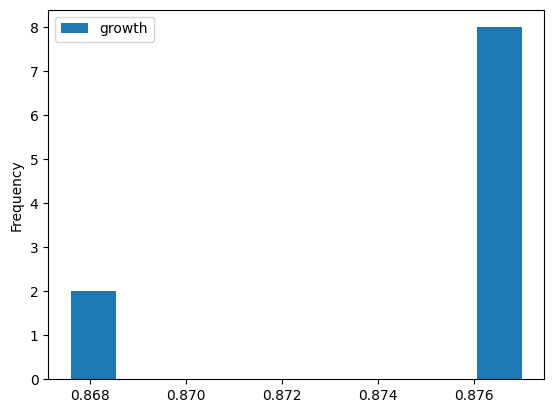

In [587]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame.from_dict(essentiality, orient='index')
df = df.rename(columns={0: 'growth'})
df = df.sort_values('growth')
df.plot.hist()

22.823896531250035
22.823896531250035
0.45
22.823896531249527
22.823896531249527
0.45


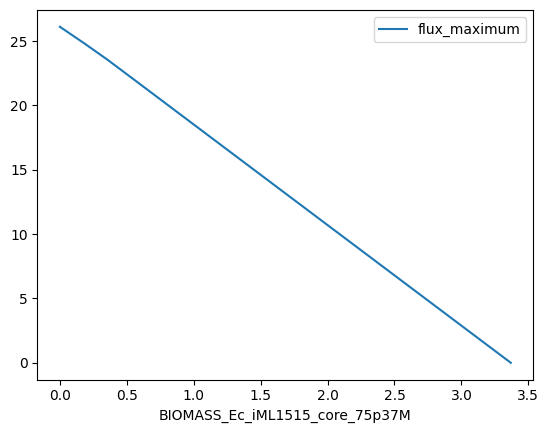

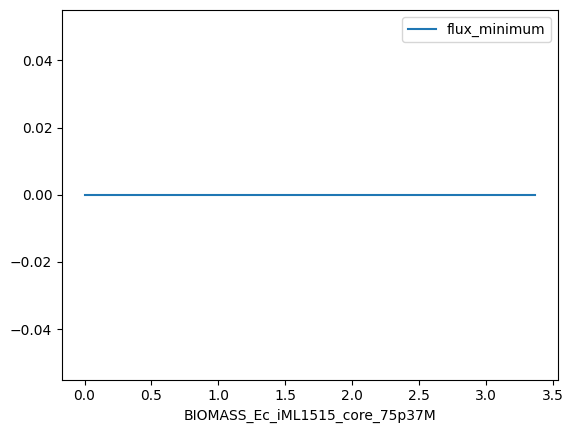

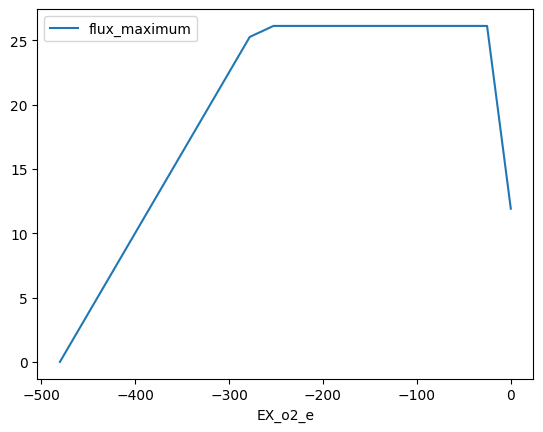

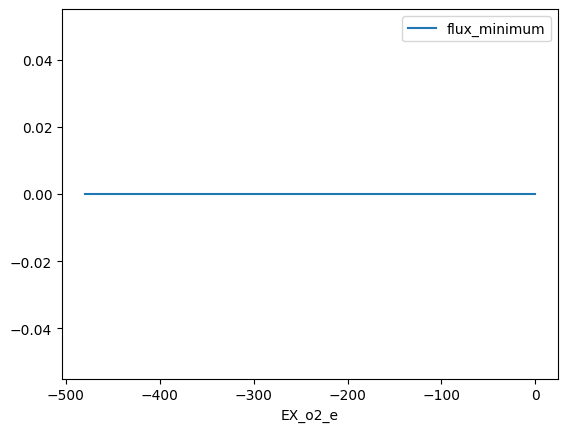

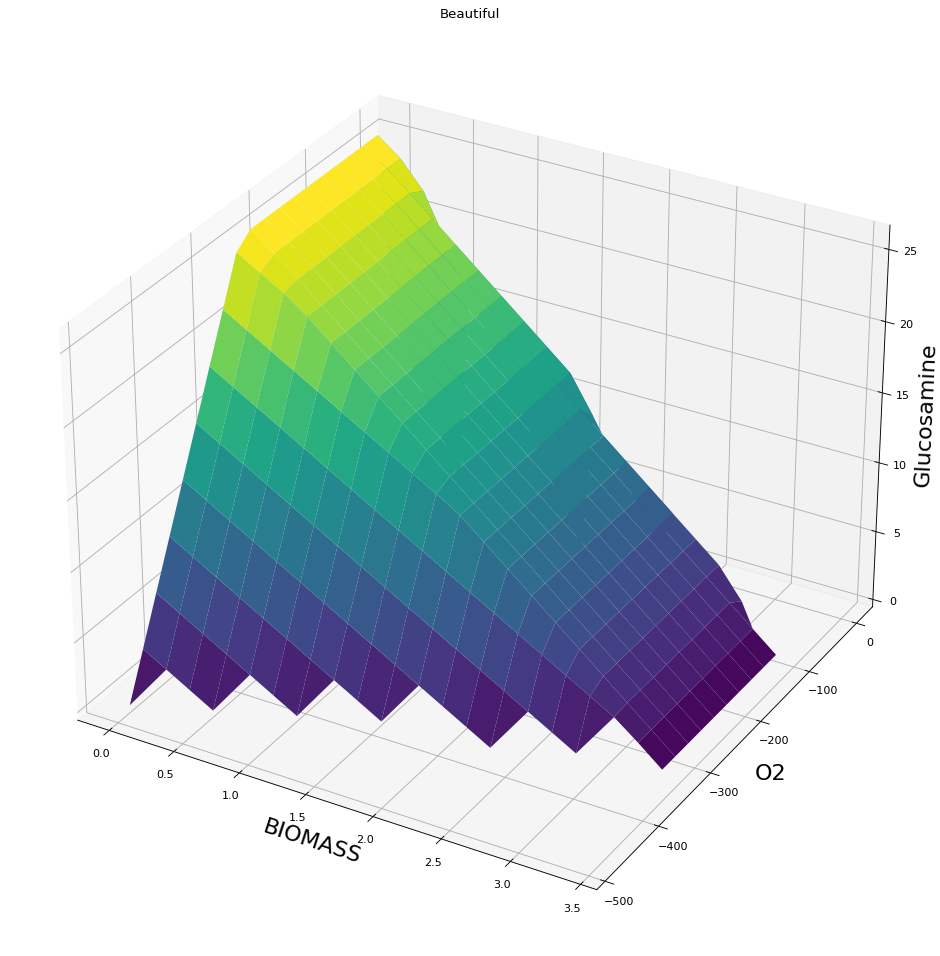

In [588]:
medium = model.medium
with model:
    # media
    medium['EX_glc__D_e'] = 30
    medium['EX_rib__D_e'] = 10
    medium['EX_chtbs_e'] = 0
    model.medium = medium
    
    # gene knockout
    model.genes.get_by_id("b0677").knock_out()
    model.genes.get_by_id("b0678").knock_out()
    model.genes.get_by_id("b0679").knock_out()
    model.genes.get_by_id("b1817").knock_out()
    model.genes.get_by_id("b1818").knock_out()
    model.genes.get_by_id("b1819").knock_out()
    model.genes.get_by_id("b1101").knock_out()
    model.genes.get_by_id("b2415").knock_out()
    model.genes.get_by_id("b2416").knock_out()
    model.genes.get_by_id("b2417").knock_out()
    
    # gene integration
    reaction = Reaction("ExRe1")
    reaction.name = "GlcNAc-6-P N-Acetyltransferase"
    reaction.lower_bound = 0
    reaction.upper_bound = 1000

    reaction.add_metabolites({
        model.metabolites.get_by_id("accoa_c"): -1.0,
        model.metabolites.get_by_id("gam6p_c"): -1.0,
        model.metabolites.get_by_id("acgam6p_c"): 1.0,
        model.metabolites.get_by_id("coa_c"): 1.0,
        model.metabolites.get_by_id("h_c"): 1.0,
    })
    model.add_reactions([reaction])
    reaction = Reaction("ExRe2")
    reaction.name = "GlcNAc-6-P phosphatase"
    reaction.lower_bound = 0
    reaction.upper_bound = 1000

    reaction.add_metabolites({
        model.metabolites.get_by_id("acgam6p_c"): -1.0,
        model.metabolites.get_by_id("h2o_p"): -1.0,
        model.metabolites.get_by_id("pi_p"): 1.0,
        model.metabolites.get_by_id("acgam_p"): 1.0
    })
    model.add_reactions([reaction])

    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45
    model.objective = model.reactions.ExRe2
    solution = model.optimize()

    print(solution.fluxes["ExRe1"])
    print(solution.fluxes["ExRe2"])   
    print(solution.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])
    
    moma_res = moma(model, solution)
    print(moma_res.fluxes["ExRe1"])
    print(moma_res.fluxes["ExRe2"])   
    print(moma_res.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])
    
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0
    
    # PPP
    growth = production_envelope(model, reactions=model.reactions.BIOMASS_Ec_iML1515_core_75p37M, 
                               objective=model.reactions.ExRe2)
    growth.plot(x='BIOMASS_Ec_iML1515_core_75p37M', y='flux_maximum')
    growth.plot(x="BIOMASS_Ec_iML1515_core_75p37M", y= "flux_minimum")  
    
    oxy = production_envelope(model, reactions=model.reactions.EX_o2_e, 
                               objective=model.reactions.ExRe2)
    oxy.plot(x='EX_o2_e', y='flux_maximum')
    oxy.plot(x="EX_o2_e", y= "flux_minimum")  
    
    result_3D = production_envelope(model, reactions=[model.reactions.BIOMASS_Ec_iML1515_core_75p37M, model.reactions.EX_o2_e],
                                   objective=model.reactions.ExRe2)
    fig = plt.figure(figsize=(15, 15), dpi=80)
    ax = plt.axes(projection='3d')
    ax.plot_surface(np.reshape(np.asarray(result_3D.BIOMASS_Ec_iML1515_core_75p37M), (-1, 20)), 
                    np.reshape(np.asarray(result_3D.EX_o2_e), (-1, 20)), 
                    np.reshape(np.asarray(result_3D.flux_maximum), (-1, 20)),
                    rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('Beautiful')
    ax.set_xlabel('BIOMASS', fontsize=20, rotation = 0)
    ax.set_ylabel('O2', fontsize=20, rotation = 0)
    ax.set_zlabel('Glucosamine', fontsize=20, rotation = 0)

# FVA

In [652]:
from cameo import flux_variability_analysis as flux_vari_analysis

In [653]:
# media
medium = model.medium
medium['EX_glc__D_e'] = 30
medium['EX_rib__D_e'] = 10
model.medium = medium

model.genes.get_by_id("b0677").knock_out()
model.genes.get_by_id("b0678").knock_out()
model.genes.get_by_id("b0679").knock_out()
model.genes.get_by_id("b1817").knock_out()
model.genes.get_by_id("b1818").knock_out()
model.genes.get_by_id("b1819").knock_out()
model.genes.get_by_id("b1101").knock_out()
model.genes.get_by_id("b2415").knock_out()
model.genes.get_by_id("b2416").knock_out()
model.genes.get_by_id("b2417").knock_out()

#gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("ac_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("h2o_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("pyr_c"): -1.0,
    model.metabolites.get_by_id("pep_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])



Ignoring reaction 'ExRe1' since it already exists.
Ignoring reaction 'ExRe2' since it already exists.


In [654]:
fva_result = flux_vari_analysis(model)

In [655]:
fva_result.plot(plotter, 
                index=fva_result.data_frame.index[2700:2714]
               )

In [656]:
fva_result2 = flux_vari_analysis(model,fraction_of_optimum=0.95)

In [657]:
fva_result2.plot(plotter, index=fva_result.data_frame.index[2700:2714])

### Downregulate

In [660]:
a = fva_result2.data_frame["lower_bound"] - fva_result.data_frame["upper_bound"]

In [661]:
a[a > 0]

DBTS         3.904189e-06
DM_amob_c    1.796152e-06
EX_meoh_e    7.439959e-08
MOBDabcpp    2.714837e-06
MOBDtex      2.714837e-06
AMAOTr       1.802271e-06
MALCOAMT     6.961016e-09
OGMEACPS     1.846520e-06
OGMEACPR     1.846520e-06
OPMEACPS     1.846520e-06
AOXSr2       3.780954e-06
dtype: float64

### Upregulate

In [662]:
b = fva_result2.data_frame["upper_bound"] - fva_result.data_frame["lower_bound"]

In [636]:
b[b < 0]

EX_mobd_e   -4.924759e-07
MEOHtrpp    -4.063434e-07
MEOHtex     -5.550844e-06
dtype: float64

In [663]:
from cobra.flux_analysis import flux_variability_analysis
x=[]
y=[]
z=[]
k=[]
m=[]
Biomass=[]
Productivity1=[]
Productivity2=[]
Glucosamine=[]
optimum_value=[]
with model:
    model.objective = "EX_acgam_e"
    optimum=model.optimize().objective_value
    i=0.05
    while i<1:
        FVA=flux_variability_analysis(model,model.reactions.BIOMASS_Ec_iML1515_core_75p37M,fraction_of_optimum=i)
        Biomass.append(FVA.maximum.item())
        Productivity1.append(-i*optimum*FVA.maximum.item()/model.optimize().fluxes['EX_glc__D_e'])
        Productivity2.append(-i*optimum*FVA.maximum.item()/model.optimize().fluxes['EX_rib__D_e'])
        Glucosamine.append(i*optimum)
        optimum_value.append(i)
        i+=0.05 
    x.append(Biomass)
    y.append(Productivity1)
    z.append(Glucosamine)
    k.append(optimum_value)
    m.append(Productivity2)

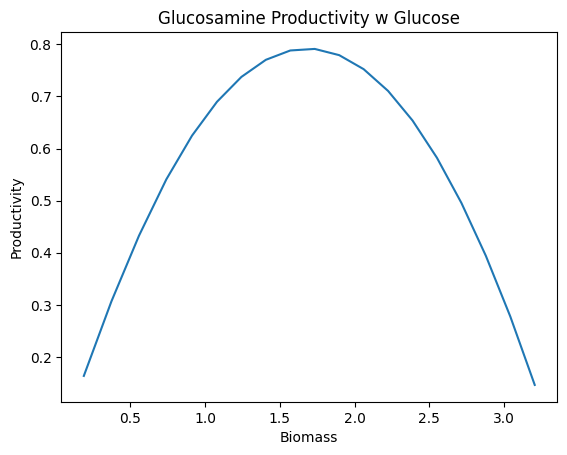

In [664]:
import matplotlib.pyplot as plt
for i in range (0,len(y)):
    plt.figure()
    plt.plot(x[i],y[i])
    plt.xlabel("Biomass")
    plt.ylabel("Productivity")
    plt.title('Glucosamine Productivity w Glucose') 
plt.show()

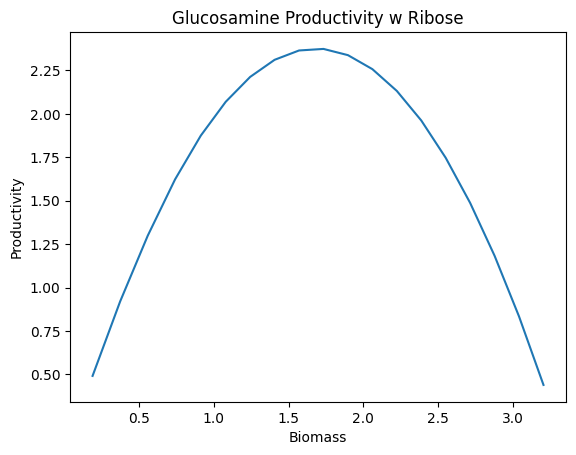

In [665]:
import matplotlib.pyplot as plt
for i in range (0,len(y)):
    plt.figure()
    plt.plot(x[i],m[i])
    plt.xlabel("Biomass")
    plt.ylabel("Productivity")
    plt.title('Glucosamine Productivity w Ribose') 
plt.show()

In [666]:
a=np.concatenate((np.asanyarray(x).flatten(),np.asanyarray(x).flatten()))

In [667]:
a=a.reshape(-1,19)

In [668]:
b=np.concatenate((np.asanyarray(m).flatten(),np.asanyarray(y).flatten()))
b=b.reshape(-1,19)

In [669]:
c=np.concatenate((np.asanyarray(y).flatten(),np.asanyarray(y).flatten()))
c=c.reshape(-1,19)

Text(0.5, 0, 'Growth')

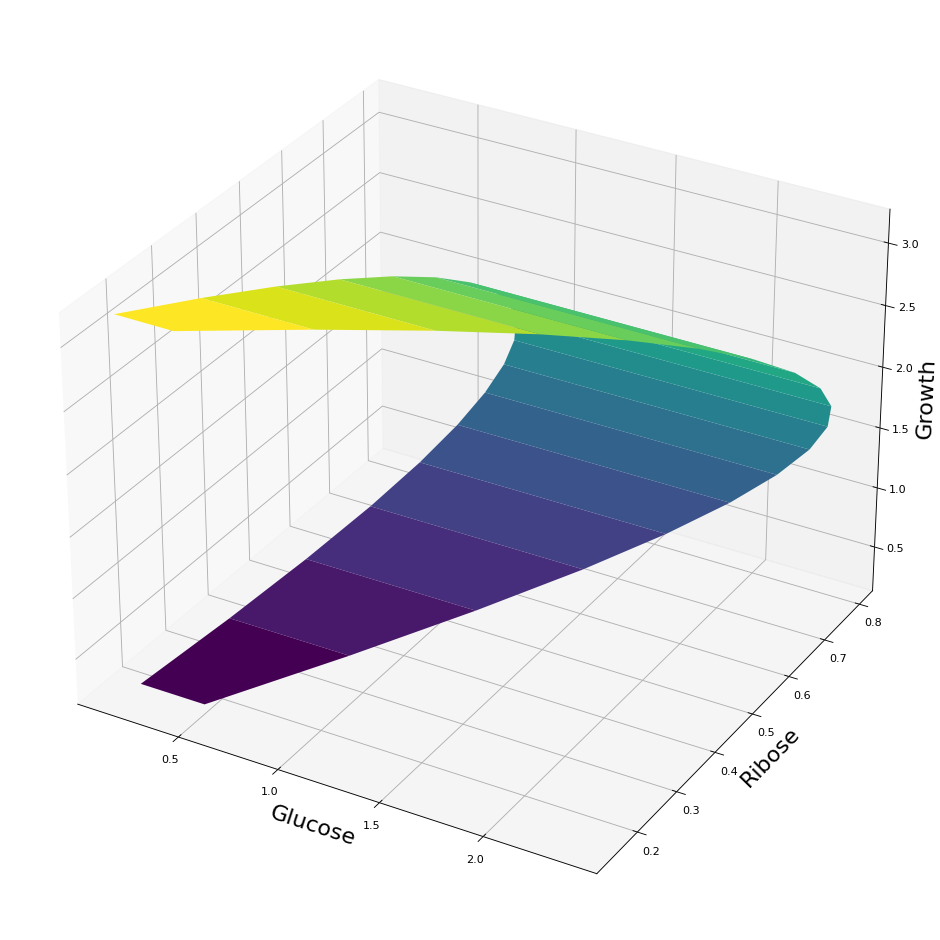

In [670]:
fig = plt.figure(figsize=(15, 15), dpi=80)
ax = plt.axes(projection='3d')
ax.plot_surface(b,c,a,
                rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('Glucose', fontsize=20, rotation = 0)
ax.set_ylabel('Ribose', fontsize=20, rotation = 0)
ax.set_zlabel('Growth', fontsize=20, rotation = 0)

In [671]:
Biomass_sorted,Productivity1_sorted,Productivity2_sorted,GLSsorted,optimum_value_sorted = zip(*sorted(list(zip(Biomass, Productivity1,Productivity2,Glucosamine,optimum_value)), key=lambda item: item[1], reverse=True))
print("The highest productivity will be reached when:")
print("growth rate is ", Biomass_sorted[1], "/h,") # Higer than literature value
print("and the corresponding productivity will be", Productivity1_sorted[1], "mol/mol/h")
print("and the corresponding productivity will be", Productivity2_sorted[1], "mol/mol/h")
print("The Glucosamine production rate will be",GLSsorted[1], "mmol/gdcw/h." )
print("The optimum value set for production of Glucosamine is",  optimum_value_sorted[1])

The highest productivity will be reached when:
growth rate is  1.570124944815215 /h,
and the corresponding productivity will be 0.7883422889589993 mol/mol/h
and the corresponding productivity will be 2.365026866876998 mol/mol/h
The Glucosamine production rate will be 15.062666666666667 mmol/gdcw/h.
The optimum value set for production of Glucosamine is 0.5499999999999999


In [672]:
Biomass_sorted,Productivity1_sorted,Productivity2_sorted,GLSsorted,optimum_value_sorted = zip(*sorted(list(zip(Biomass, Productivity1,Productivity2,Glucosamine,optimum_value)), key=lambda item: item[2], reverse=True))
print("The highest productivity will be reached when:")
print("growth rate is ", Biomass_sorted[1], "/h,") # Higer than literature value
print("and the corresponding productivity will be", Productivity1_sorted[1], "mol/mol/h")
print("and the corresponding productivity will be", Productivity2_sorted[1], "mol/mol/h")
print("The Glucosamine production rate will be",GLSsorted[1], "mmol/gdcw/h." )
print("The optimum value set for production of Glucosamine is",  optimum_value_sorted[1])

The highest productivity will be reached when:
growth rate is  1.570124944815215 /h,
and the corresponding productivity will be 0.7883422889589993 mol/mol/h
and the corresponding productivity will be 2.365026866876998 mol/mol/h
The Glucosamine production rate will be 15.062666666666667 mmol/gdcw/h.
The optimum value set for production of Glucosamine is 0.5499999999999999


## Overexpression

In [678]:
model_growth = model.copy()

In [683]:
model_growth.objective = "BIOMASS_Ec_iML1515_core_75p37M"
model.objective = "ExRe2"
model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45 # Paper reference

In [707]:
model.reactions.GF6PTA

Reaction identifier,GF6PTA
Name,Glutamine-fructose-6-phosphate transaminase
Memory address,0x24c652b3dc0
Stoichiometry,f6p_c + gln__L_c --> gam6p_c + glu__L_c D-Fructose 6-phosphate + L-Glutamine --> D-Glucosamine 6-phosphate + L-Glutamate
GPR,b3729
Lower bound,0.0
Upper bound,1000.0


In [705]:
print("Compare the optimum flux with original model optimised only for cell growth, the expression levels are increased as follows:")
print("For Glutamine-fructose-6-phosphate transaminase: the flux increased from", model_growth.optimize().fluxes['GF6PTA'], "to", model.optimize().fluxes['GF6PTA'])

print("For Glutamine-fructose-6-phosphate transaminase, flux increased by:" , (model.optimize().fluxes['GF6PTA'] - model_growth.optimize().fluxes['GF6PTA'])/model_growth.optimize().fluxes['GF6PTA'] * 100, "%")

print("For Glutamine-fructose-6-phosphate transaminase, flux increased by:" , (model.optimize().fluxes['GF6PTA'] - model_growth.optimize().fluxes['GF6PTA'])/model_growth.optimize().fluxes['GF6PTA'] * 100, "%")



Compare the optimum flux with original model optimised only for cell growth, the expression levels are increased as follows:
For Glutamine-fructose-6-phosphate transaminase: the flux increased from 0.31834025482244155 to 24.12030031560982
For Glutamine-fructose-6-phosphate transaminase, flux increased by: 7476.892947159081 %


In [576]:
model = read_sbml_model('iML1515.xml')  

## Using networkx to analyze the network

In [353]:
model.reactions.PGAMT

Reaction identifier,PGAMT
Name,Phosphoglucosamine mutase
Memory address,0x24c6355daf0
Stoichiometry,gam1p_c <=> gam6p_c D-Glucosamine 1-phosphate <=> D-Glucosamine 6-phosphate
GPR,b3176
Lower bound,-1000.0
Upper bound,1000.0


In [502]:
#set the bounds of SQLS
model.reactions.get_by_id('GF6PTA').bounds = (24.12030031560728,24.12030031560728)
print("The optimal fluxes of the reaction corresponding to the overexpression genes are:")
print("For Squalene synthase: ", model.optimize().fluxes['GF6PTA'])

The optimal fluxes of the reaction corresponding to the overexpression genes are:
For Squalene synthase:  24.12030031560728


In [ ]:
#To compare with model optimised for cell growth
model_growth=read_sbml_model('iJN678mod.xml')  
model_growth.objective = "BIOMASS_Ec_SynAuto"

In [17]:
from cobra.util import create_stoichiometric_matrix
S = create_stoichiometric_matrix(model)

In [18]:
S

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
import numpy as np
S_hat = np.where(S==0, S, 1)
A_v = S_hat.T @ S_hat
A_x = S_hat @ S_hat.T

In [20]:
import networkx as nx

In [21]:
compound_centric_network = nx.from_numpy_matrix(A_x)

In [22]:
mapping = dict(zip(range(0, len(model.metabolites)), model.metabolites))
compound_centric_network = nx.relabel_nodes(compound_centric_network, mapping)

In [23]:
metabolite_degrees = compound_centric_network.degree()

In [24]:
sorted_metabolite_degrees = sorted(metabolite_degrees, key=lambda item: item[1], reverse=True)
sorted_metabolite_degrees[0:10]

[(<Metabolite h_c at 0x169647b5970>, 1216),
 (<Metabolite h2o_c at 0x16964a6f3d0>, 864),
 (<Metabolite atp_c at 0x169648ff220>, 610),
 (<Metabolite pi_c at 0x169648b4100>, 557),
 (<Metabolite adp_c at 0x16964880400>, 525),
 (<Metabolite h_p at 0x16964832eb0>, 479),
 (<Metabolite ppi_c at 0x1696499fe80>, 302),
 (<Metabolite nad_c at 0x16964845dc0>, 298),
 (<Metabolite nadp_c at 0x1696499f220>, 294),
 (<Metabolite nadph_c at 0x16964b3f5e0>, 294)]

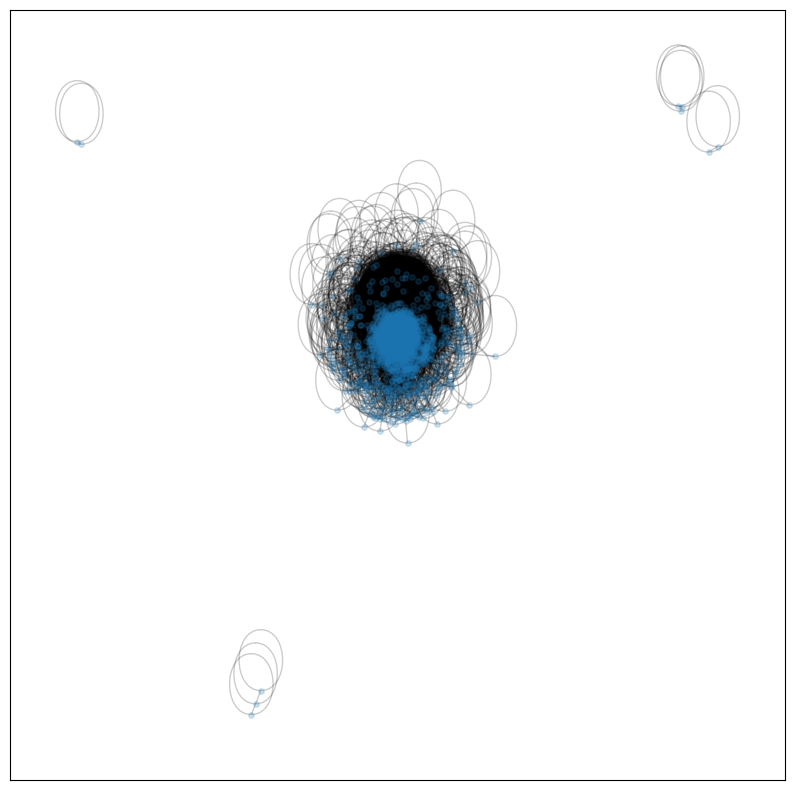

In [25]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(compound_centric_network, node_size=15, alpha=.2, with_labels=False)

In [26]:
a=list(compound_centric_network.nodes)[565]
b=list(compound_centric_network.nodes)[420]
for i in range(len(list(compound_centric_network.nodes))):
    print(i, list(compound_centric_network.nodes)[i])

0 octapb_c
1 cysi__L_e
2 dhap_c
3 prbatp_c
4 10fthf_c
5 btal_c
6 6pgg_c
7 co2_e
8 akg_e
9 gsn_e
10 pydx5p_c
11 3dhgulnp_c
12 g3ps_c
13 adphep_LD_c
14 lyx__L_c
15 din_p
16 2pg_c
17 ptrc_p
18 malt_p
19 pppn_p
20 arbtn_p
21 hphhlipa_c
22 phphhlipa_c
23 13dpg_c
24 murein3px4p_p
25 34dhpac_e
26 1odec11eg3p_c
27 12dgr181_p
28 anhgm_e
29 prbamp_c
30 dsbdrd_c
31 cu2_p
32 sla_c
33 14glucan_p
34 grdp_c
35 ribflv_p
36 dms_e
37 pgp141_c
38 cysi__L_c
39 fpram_c
40 f1p_c
41 dsbard_p
42 thr__L_c
43 dcyt_p
44 2ddglcn_c
45 fum_p
46 galctn__L_e
47 btn_e
48 pydxn_p
49 ocdcea_e
50 preq0_c
51 tyr__L_p
52 dtdp4d6dg_c
53 acmum_e
54 man_p
55 adocbl_e
56 iscu_2fe2s_c
57 frulysp_c
58 dump_p
59 novbcn_e
60 feenter_e
61 eca4und_p
62 gg4abut_c
63 flxr_c
64 pa160_c
65 lcts_c
66 arbtn_e
67 cdpdhdec9eg_c
68 aso3_c
69 progly_c
70 3ohdcoa_c
71 clpn161_p
72 1ddecg3p_p
73 gln__L_e
74 cpgn_un_e
75 ca2_p
76 tre_e
77 iscssh_c
78 glyald_c
79 alaala_e
80 novbcn_p
81 3ohexACP_c
82 g3pg_c
83 rpntp_c
84 adocbl_c
85 3ocddec5eACP_

In [27]:
print(nx.shortest_path(compound_centric_network, source=a, target=b))

[<Metabolite glc__D_c at 0x169648e8850>, <Metabolite h_c at 0x169647b5970>, <Metabolite uacgam_c at 0x16964b0ceb0>, <Metabolite puacgam_c at 0x1696499fe50>, <Metabolite puacgam_p at 0x16964880730>]


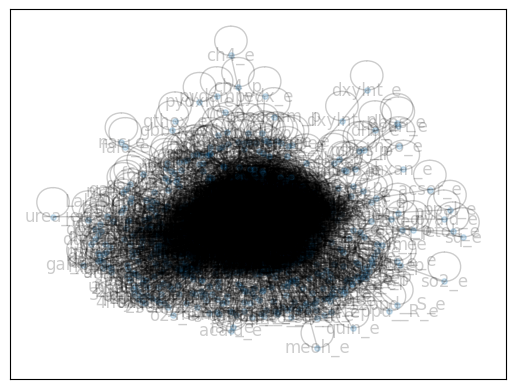

In [28]:
A = (compound_centric_network.subgraph(c) for c in nx.connected_components(compound_centric_network))
A = list(A)[0]
nx.draw_networkx(A, node_size=15, alpha=.2, with_labels=True)

In [29]:
acgam_p = list(compound_centric_network.nodes)[1607]
acgam6p_c = list(compound_centric_network.nodes)[133]
gam6p_c = list(compound_centric_network.nodes)[1443]
for i in range(len(list(compound_centric_network.nodes))):
    print(i, list(compound_centric_network.nodes)[i])

0 octapb_c
1 cysi__L_e
2 dhap_c
3 prbatp_c
4 10fthf_c
5 btal_c
6 6pgg_c
7 co2_e
8 akg_e
9 gsn_e
10 pydx5p_c
11 3dhgulnp_c
12 g3ps_c
13 adphep_LD_c
14 lyx__L_c
15 din_p
16 2pg_c
17 ptrc_p
18 malt_p
19 pppn_p
20 arbtn_p
21 hphhlipa_c
22 phphhlipa_c
23 13dpg_c
24 murein3px4p_p
25 34dhpac_e
26 1odec11eg3p_c
27 12dgr181_p
28 anhgm_e
29 prbamp_c
30 dsbdrd_c
31 cu2_p
32 sla_c
33 14glucan_p
34 grdp_c
35 ribflv_p
36 dms_e
37 pgp141_c
38 cysi__L_c
39 fpram_c
40 f1p_c
41 dsbard_p
42 thr__L_c
43 dcyt_p
44 2ddglcn_c
45 fum_p
46 galctn__L_e
47 btn_e
48 pydxn_p
49 ocdcea_e
50 preq0_c
51 tyr__L_p
52 dtdp4d6dg_c
53 acmum_e
54 man_p
55 adocbl_e
56 iscu_2fe2s_c
57 frulysp_c
58 dump_p
59 novbcn_e
60 feenter_e
61 eca4und_p
62 gg4abut_c
63 flxr_c
64 pa160_c
65 lcts_c
66 arbtn_e
67 cdpdhdec9eg_c
68 aso3_c
69 progly_c
70 3ohdcoa_c
71 clpn161_p
72 1ddecg3p_p
73 gln__L_e
74 cpgn_un_e
75 ca2_p
76 tre_e
77 iscssh_c
78 glyald_c
79 alaala_e
80 novbcn_p
81 3ohexACP_c
82 g3pg_c
83 rpntp_c
84 adocbl_c
85 3ocddec5eACP_

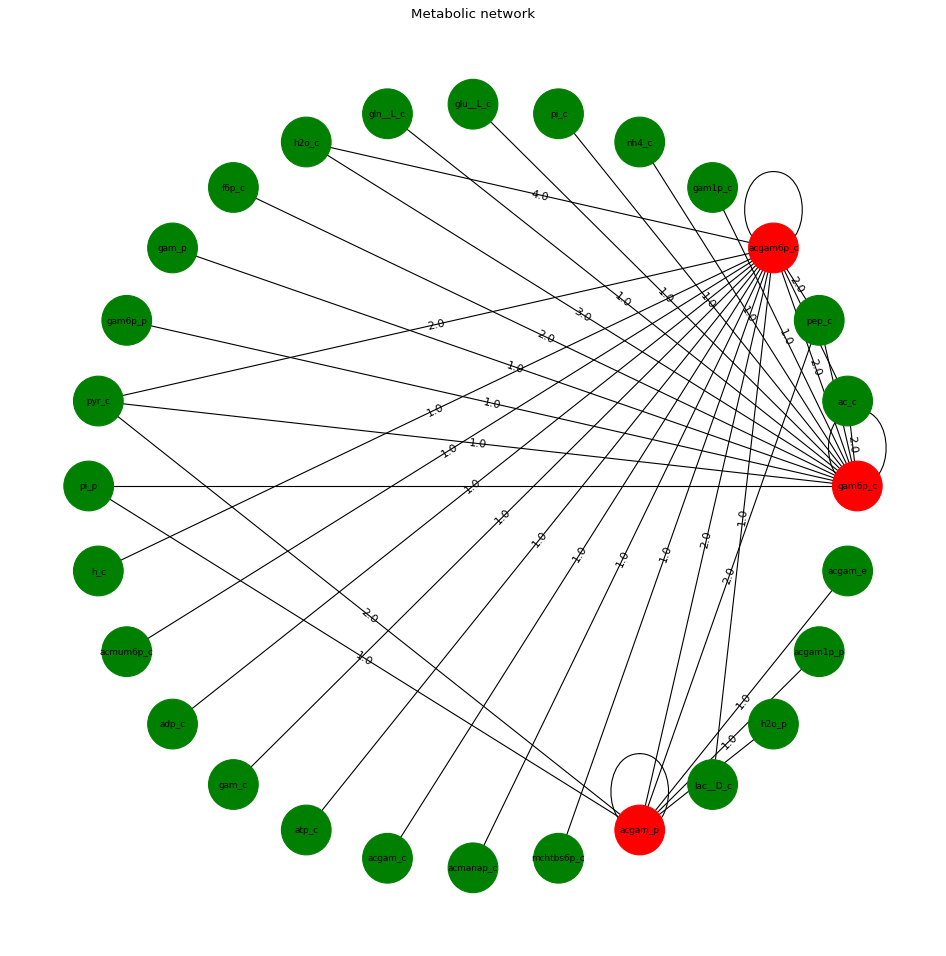

In [30]:
def check_neighbor_weights(g,nodes):
    subg=nx.Graph() #Create subgraph
    for n in nodes:
        subg.add_node(n)
        neighbors=g.neighbors(n) #Find all neighbors of node n
        for neighs in neighbors:
            if g[n][neighs]['weight']<50: #Check if the weigh t is below 50
                subg.add_edge(n,neighs,weight=g[n][neighs]['weight'])
    return subg

subg=check_neighbor_weights(compound_centric_network,[gam6p_c, acgam6p_c, acgam_p]) #Returns subgraph of interest

color_map = []
for node in subg.nodes():
    if node in [gam6p_c, acgam6p_c, acgam_p]:
        color_map.append('red')
    else: 
        color_map.append('green')      


plt.figure(figsize=(15, 15), dpi=80)
plt.title('Metabolic network')
labels_subg = nx.get_edge_attributes(subg,'weight')
pos_subg=nx.circular_layout(subg)
nx.draw_networkx_edge_labels(subg,pos=pos_subg,edge_labels=labels_subg)
nx.draw(subg,pos=pos_subg,with_labels=True,node_color=color_map,node_size=2000,font_size=8)

plt.show()

# OptGene

In [18]:
from cameo.strain_design.heuristic.evolutionary_based import OptGene

In [19]:
optgene = OptGene(model)

In [20]:
result = optgene.run(target=model.reactions.ExRe2, 
                     biomass=model.reactions.BIOMASS_Ec_iML1515_core_75p37M,
                     substrate=model.metabolites.glc__D_e,
                     max_evaluations=20000, population_size=200, max_knockouts=5,
                     plot=False, growth_coupled=True)

Starting optimization at Tue, 22 Nov 2022 16:16:44


HBox()

Finished after 09:30:23


In [21]:
result

No solutions found


IndexError: index 0 is out of bounds for axis 0 with size 0

# dFBA

In [2]:
from dfba import DfbaModel, ExchangeFlux, KineticVariable

model = read_sbml_model('iML1515.xml')

In [3]:
# media
medium = model.medium
medium['EX_glc__D_e'] = 30
medium['EX_rib__D_e'] = 10
model.medium = medium

model.genes.get_by_id("b0677").knock_out()
model.genes.get_by_id("b0678").knock_out()
model.genes.get_by_id("b0679").knock_out()
model.genes.get_by_id("b1817").knock_out()
model.genes.get_by_id("b1818").knock_out()
model.genes.get_by_id("b1819").knock_out()
model.genes.get_by_id("b1101").knock_out()
model.genes.get_by_id("b2415").knock_out()
model.genes.get_by_id("b2416").knock_out()
model.genes.get_by_id("b2417").knock_out()

#gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("ac_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("h2o_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("pyr_c"): -1.0,
    model.metabolites.get_by_id("pep_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])

model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.7
model.objective = model.reactions.ExRe2

In [4]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [5]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Rib = KineticVariable("Ribose")
Oxy = KineticVariable("Oxygen")
Gluc_amine = KineticVariable("Glucosamine")

dfba_model.add_kinetic_variables([X, Gluc, Rib, Oxy, Gluc_amine])

In [6]:
mu = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_G = ExchangeFlux("EX_glc__D_e")
v_R = ExchangeFlux("EX_rib__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_GS = ExchangeFlux("EX_acgam_e")

dfba_model.add_exchange_fluxes([mu, v_G, v_R, v_O, v_GS])

In [10]:
dfba_model.add_rhs_expression("Biomass", mu * X - 0.461 * X)
# dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
# dfba_model.add_rhs_expression("Ribose", v_R * 150.13/1000 * X)
dfba_model.add_rhs_expression("Glucose", 0) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Ribose", 0)
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant
dfba_model.add_rhs_expression("Glucosamine", v_GS * 221.2078/1000 * X)

In [11]:
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)


vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb(
    "EX_glc__D_e",
    vmax_glc * (Gluc / (Kg + Gluc)),
    Gluc
)

vmax_rib = 6 # [mmol gDW^-1 h^-1]
Kr = 0.0165
dfba_model.add_exchange_flux_lb(
    "EX_rib__D_e",
    vmax_rib 
    * (Rib / (Kr + Rib)),
    Rib,
)

dfba_model.add_exchange_flux_lb(
    "BIOMASS_Ec_iML1515_core_75p37M",
    0.45 * (X / (0.1 + X)),
    X,
)


In [12]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 30, # (g/L)
        "Ribose": 10.0,   # (g/L)
        "Oxygen": 0.5,  # (mmol/L)
        "Glucosamine": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 100.0, 0.1, ["EX_glc__D_e", "EX_rib__D_e", "EX_acgam_e", "BIOMASS_Ec_iML1515_core_75p37M"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 0
Number of residual evaluations     = 0
Number of Jacobian evaluations     = 20
Number of nonlinear iterations     = 0
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 0

Total simulation time was 4.16797 seconds



In [13]:
concentrations

,time,Biomass,Glucosamine,Glucose,Oxygen,Ribose
0,0.0,0.010000,0.000000,30.0,0.5,10.0
1,0.1,0.010200,0.037204,30.0,0.5,10.0
2,0.2,0.010403,0.075153,30.0,0.5,10.0
3,0.3,0.010609,0.113864,30.0,0.5,10.0
4,0.4,0.010818,0.153339,30.0,0.5,10.0
...,...,...,...,...,...,...
996,99.6,0.113254,355.282977,30.0,0.5,10.0
997,99.7,0.113254,355.700350,30.0,0.5,10.0
998,99.8,0.113254,356.117723,30.0,0.5,10.0
999,99.9,0.113254,356.535096,30.0,0.5,10.0


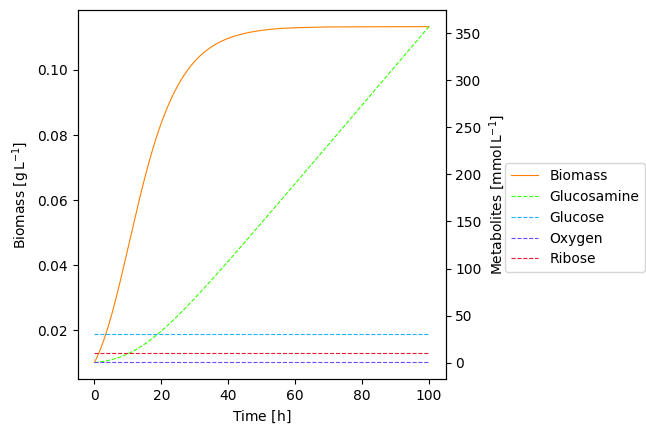

In [14]:
from dfba.plot.matplotlib import *
plot_concentrations(concentrations)

In [15]:
trajectories

,time,EX_glc__D_e,EX_rib__D_e,EX_acgam_e,BIOMASS_Ec_iML1515_core_75p37M
0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.1,-10.499055,-5.990116,166.527689,0.658350
2,0.2,-10.499055,-5.990116,166.527954,0.657599
3,0.3,-10.499055,-5.990116,166.528222,0.656839
4,0.4,-10.499055,-5.990116,166.528493,0.656071
...,...,...,...,...,...
996,99.6,-10.499055,-5.990116,166.597336,0.461016
997,99.7,-10.499055,-5.990116,166.597336,0.461016
998,99.8,-10.499055,-5.990116,166.597336,0.461016
999,99.9,-10.499055,-5.990116,166.597336,0.461015


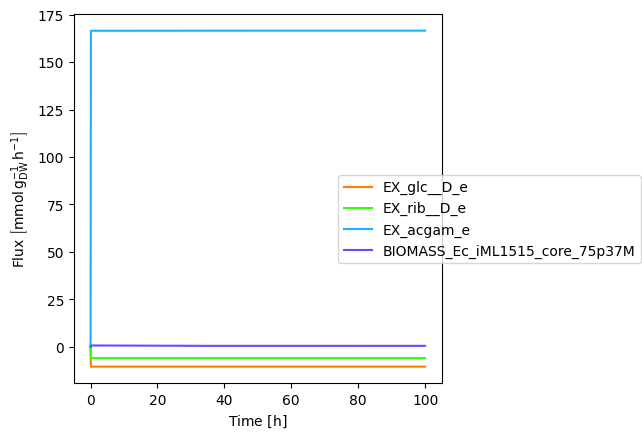

In [16]:
plot_trajectories(trajectories)

# FSEOF

In [31]:
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [32]:
fseof = FSEOF(model)

In [33]:
result = fseof.run(target=model.reactions.ExRe2)

In [34]:
result.data_frame #52 reacitons

,1,2,3,4,5,6,7,8,9,10
NDPK8,-0.080453,-0.072751,-0.065048,-0.057345,-0.049642,-0.041940,-0.034237,-0.026534,-0.018428,-6.825852
PYNP2r,0.080453,0.072751,0.065048,0.057345,0.049642,0.041940,0.034237,0.026534,0.018428,0.009764
DURIPP,-0.080453,-0.072751,-0.065048,-0.057345,-0.049642,-0.041940,-0.034237,-0.026534,-0.018428,-0.009764
ACALD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.816088
PPM,-0.002069,-0.001871,-0.001673,-0.001475,-0.001277,-0.001079,-0.000881,-0.000682,-0.000474,-6.816339
PYK,46.395102,46.440128,46.485153,46.530179,46.575205,46.620230,46.665256,46.710282,48.821904,44.474687
VALTA,-3.090121,-2.794268,-2.498416,-2.202563,-1.906710,-1.610857,-1.315005,-1.019152,-0.707779,-0.375035
PFK_3,28.604352,26.523032,24.441712,22.360391,20.279071,18.197751,16.116430,14.035110,13.870664,7.149899
PFL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.557076,0.661267
PTAr,0.674736,3.310919,5.947103,8.583286,11.219469,13.855653,16.491836,19.128020,21.773194,24.430748


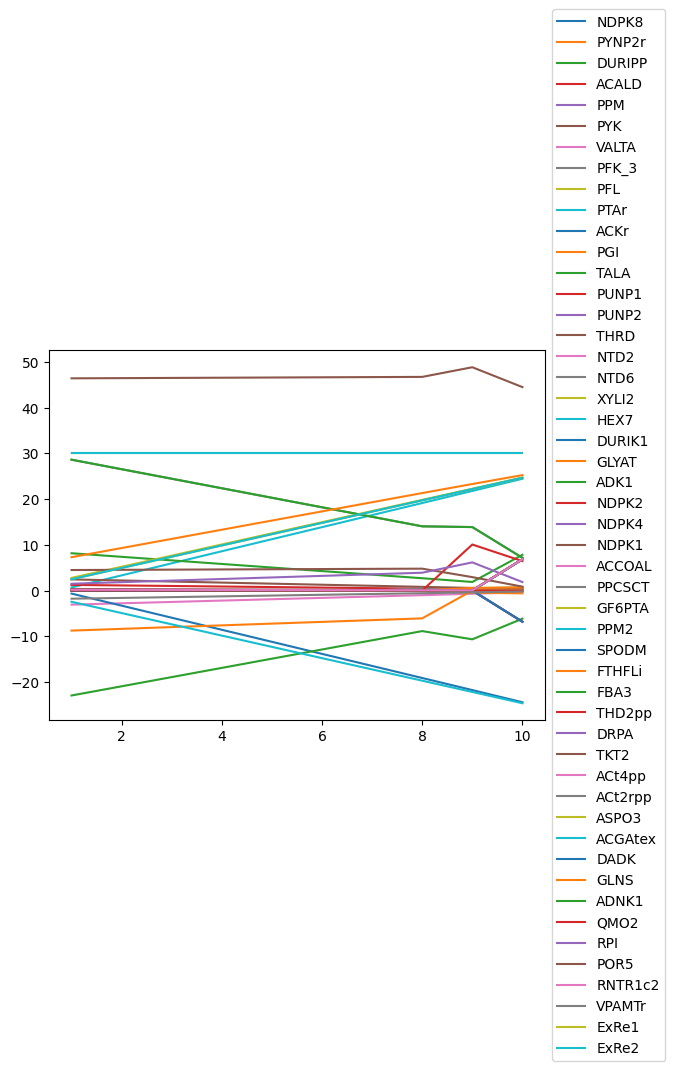

In [35]:
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [86]:
res = result.data_frame

In [90]:
res["diff"] = abs(result.data_frame[:][10] - result.data_frame[:][1])

In [92]:
res = res.sort_values("diff", ascending=False)
res

,1,2,3,4,5,6,7,8,9,10,diff
PTAr,0.674736,3.310919,5.947103,8.583286,11.219469,13.855653,16.491836,19.128020,21.773194,24.430748,23.756012
ACKr,-0.674736,-3.310919,-5.947103,-8.583286,-11.219469,-13.855653,-16.491836,-19.128020,-21.773194,-24.430748,23.756012
ExRe2,2.464800,4.929600,7.394400,9.859200,12.324000,14.788800,17.253600,19.718400,22.183200,24.648000,22.183200
ExRe1,2.464800,4.929600,7.394400,9.859200,12.324000,14.788800,17.253600,19.718400,22.183200,24.648000,22.183200
ACGAtex,-2.464800,-4.929600,-7.394400,-9.859200,-12.324000,-14.788800,-17.253600,-19.718400,-22.183200,-24.648000,22.183200
GF6PTA,2.755325,5.192310,7.629294,10.066279,12.503264,14.940249,17.377233,19.814218,22.249744,24.683260,21.927935
PFK_3,28.604352,26.523032,24.441712,22.360391,20.279071,18.197751,16.116430,14.035110,13.870664,7.149899,21.454453
FBA3,28.604352,26.523032,24.441712,22.360391,20.279071,18.197751,16.116430,14.035110,13.870664,7.149899,21.454453
GLNS,7.281230,9.284898,11.288566,13.292234,15.295902,17.299570,19.303238,21.306906,23.286384,25.232550,17.951320
TALA,-22.956196,-20.944065,-18.931935,-16.919805,-14.907675,-12.895544,-10.883414,-8.871284,-10.676415,-6.162292,16.793904


In [96]:
res = res.iloc[:,:-1].head(20)
res

,1,2,3,4,5,6,7,8,9
PTAr,0.674736,3.310919,5.947103,8.583286,11.219469,13.855653,16.491836,19.128020,21.773194
ACKr,-0.674736,-3.310919,-5.947103,-8.583286,-11.219469,-13.855653,-16.491836,-19.128020,-21.773194
ExRe2,2.464800,4.929600,7.394400,9.859200,12.324000,14.788800,17.253600,19.718400,22.183200
ExRe1,2.464800,4.929600,7.394400,9.859200,12.324000,14.788800,17.253600,19.718400,22.183200
ACGAtex,-2.464800,-4.929600,-7.394400,-9.859200,-12.324000,-14.788800,-17.253600,-19.718400,-22.183200
GF6PTA,2.755325,5.192310,7.629294,10.066279,12.503264,14.940249,17.377233,19.814218,22.249744
PFK_3,28.604352,26.523032,24.441712,22.360391,20.279071,18.197751,16.116430,14.035110,13.870664
FBA3,28.604352,26.523032,24.441712,22.360391,20.279071,18.197751,16.116430,14.035110,13.870664
GLNS,7.281230,9.284898,11.288566,13.292234,15.295902,17.299570,19.303238,21.306906,23.286384
TALA,-22.956196,-20.944065,-18.931935,-16.919805,-14.907675,-12.895544,-10.883414,-8.871284,-10.676415


In [71]:
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Reaction identifier,FBA3
Name,"Sedoheptulose 1,7-bisphosphate D-glyceraldehyde-3-phosphate-lyase"
Memory address,0x16966563f40
Stoichiometry,"s17bp_c <=> dhap_c + e4p_c Sedoheptulose 1,7-bisphosphate <=> Dihydroxyacetone phosphate + D-Erythrose 4-phosphate"
GPR,b2925
Lower bound,-1000.0
Upper bound,1000.0


# MEMOTE

In [2]:
from cobra.io import write_sbml_model
write_sbml_model(model, "iML1515_modified.xml")

In [3]:
%%time
!memote report snapshot iML1515.xml --filename iML1515.html

Scaling...Wall time: 5min 27s


Writing snapshot report to 'iML1515.html'.



 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 155 items / 1 skipped / 154 selected

test_annotation.py ...FFFFFFFFF.FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 34%]
F..FF.FFF...                                                             [ 41%]
test_basic.py ......F............F.FF                                    [ 56%]
test_biomass.py ...F...F.....FF..FF                                      [ 69%]
test_consistency.py ...ssssssssssssssss.FFFFF.FFF                        [ 87%]
test_essentiality.py s                                                   [ 88%]
test_growth.py s                                                         [ 89%]
test_mat

In [4]:
%%time
!memote report snapshot iML1515_modified.xml --filename iML1515_modified.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 155 items / 1 skipped / 154 selected

test_annotation.py ...FFFFFFFFF.FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 34%]
F..FF.FFF...                                                             [ 41%]
test_basic.py ......F............F.FF                                    [ 56%]
test_biomass.py ...F...F.....FF..FF                                      [ 69%]
test_consistency.py ...ssssssssssssssss.FFFFF.FFF                        [ 87%]
test_essentiality.py s                                                   [ 88%]
test_growth.py s                                                         [ 89%

Writing snapshot report to 'iML1515_modified.html'.


In [5]:
%%time
!memote report snapshot iJR904.xml --filename iJR904.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 146 items / 1 skipped / 145 selected

test_annotation.py ...FFFFFFFF..FFFF..FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 36%]
F..FF.FFF...                                                             [ 44%]
test_basic.py ......F............F.FF                                    [ 60%]
test_biomass.py .F.....F.F                                               [ 67%]
test_consistency.py ...ssssssssssssssssFFFFFF.FFF                        [ 86%]
test_essentiality.py s                                                   [ 87%]
test_growth.py s                                                         [ 88%

Writing snapshot report to 'iJR904.html'.


In [6]:
%%time
!memote report snapshot iAF1260.xml --filename iAF1260.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 146 items / 1 skipped / 145 selected

test_annotation.py ...FFFFFFFF..FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 36%]
F..FF.FFF...                                                             [ 44%]
test_basic.py ......F............F.FF                                    [ 60%]
test_biomass.py .F.....F.F                                               [ 67%]
test_consistency.py ...ssssssssssssssss..FFFF.FFF                        [ 86%]
test_essentiality.py s                                                   [ 87%]
test_growth.py s                                                         [ 88%

Writing snapshot report to 'iAF1260.html'.


In [7]:
%%time
!memote report snapshot iJO1366.xml --filename iJO1366.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 155 items / 1 skipped / 154 selected

test_annotation.py ...FFFFFFFF..FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 34%]
F..FF.FFF...                                                             [ 41%]
test_basic.py ......F............F.FF                                    [ 56%]
test_biomass.py .............FF..FF                                      [ 69%]
test_consistency.py ...ssssssssssssssss..FFFF.FFF                        [ 87%]
test_essentiality.py s                                                   [ 88%]
test_growth.py s                                                         [ 89%

Writing snapshot report to 'iJO1366.html'.
